In [1]:
import matplotlib.pyplot as plt
import xtrack as xt
import scipy as sc
import bpmeth
import sympy as sp
import math
import numpy as np
from cpymad.madx import Madx
from sympy.abc import alpha, beta  # Cool notebook greek letters!
import sys
import warnings

# Daan magnet

In [2]:
rho = 2.737
phi = 60/180*np.pi
theta_E = 30/180*np.pi
l_magn = rho*phi
gap = 0.07
body_fields = [1/rho, -0.11, 0]  # Body multipole values

##################
# Daan fieldmap #
#################

# filename = "fieldmaps_Daan/Int_3_3.txt"  # Dipole field of 1.6505 T => top energy
filename = "../dipole/fieldmaps_Daan/0_0_Aperture_I_3105A.txt"  # Top energy, without shims
Brho = 1.6506*rho
data = np.loadtxt(filename, skiprows=2)[:, [0,2,1,3,5,4]] 

clean_data = data[~np.isnan(data).any(axis=1)]  # One could remove NaN rows from the fieldmap 

dipole = bpmeth.Fieldmap(clean_data)
dipole.rescale(1/Brho)
radius=0.025
dipole_FS = dipole.calc_FS_coords(XFS=np.linspace(-0.05, 0.05, 51), YFS=[0], SFS=np.arange(-1.9, 0, 0.001), rho=rho, phi=phi, radius=radius)

In [3]:
# data = np.loadtxt("../dipole/HeLICS_fieldmap_tanh.csv", skiprows=1, delimiter=',')
# dipole_FS = bpmeth.Fieldmap(data)

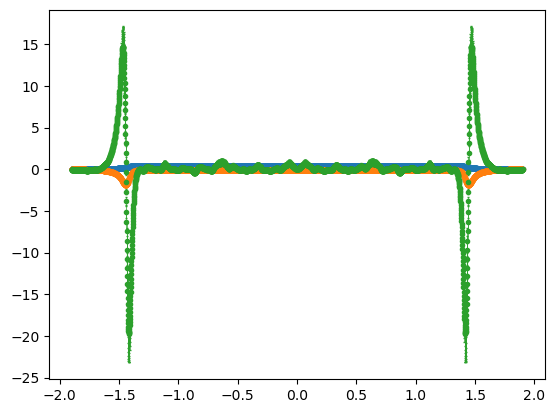

In [3]:
dipole_FS = dipole_FS.mirror()
fig, ax = plt.subplots()
zvals, coeffs, coeffsstd = dipole_FS.z_multipoles(2, ax=ax)

In [4]:
max_multipole = 3
fringe1_start = -1.7
fringe1_end = -1.31
magnet_start = -1.75
# fringe1_start = -1.7
# fringe1_end = -1.15

fringe2_start = -fringe1_end
fringe2_end = -fringe1_start

n_splits = 10
step = (np.abs(zvals-fringe1_end).argmin() - np.abs(zvals-fringe1_start).argmin()) // n_splits
split1_inds = np.sort([np.abs(zvals-fringe1_start).argmin() + i*step for i in range(n_splits+1)])
split2_inds = np.sort([np.abs(zvals-fringe2_end).argmin() - i*step for i in range(n_splits+1)])

start1_ind = split1_inds[0]
end1_ind = split1_inds[-1]
start2_ind = split2_inds[0]
end2_ind = split2_inds[-1]
magnet_start_ind = np.abs(zvals-magnet_start).argmin()
magnet_end_ind = np.abs(zvals+magnet_start).argmin()

all_pols = []
for index in range(max_multipole):
    # The actual data
    b = coeffs[:, index]
    dz = np.diff(zvals, prepend=zvals[0])
    bp = np.nan_to_num(np.diff(b,prepend=b[0])/dz, copy=True)
    
    # The points to fit
    x = zvals.copy()
    y = b.copy()
    y[start1_ind] = 0  # Force field to be zero at the start of the fringe
    y[end1_ind] = body_fields[index]  # Force field to be equal to body value at the end of the fringe
    y[start2_ind] = body_fields[index]  
    y[end2_ind] = 0
    
    yp = bp.copy()
    yp[start1_ind] = 0  # Force derivative to be zero at the start of the fringe
    yp[end1_ind] = 0  # Force derivative to be zero at the end of the fringe
    yp[start2_ind] = 0
    yp[end2_ind] = 0

    pols = [np.array([0])]
    for ia,ib in zip(split1_inds[:-1],split1_inds[1:]):
        pol=bpmeth.fit_segment(ia,ib,x,y,yp)        
        pols.append(pol)
    pols.append(np.array([body_fields[index]]))
    for ia,ib in zip(split2_inds[:-1],split2_inds[1:]):
        pol=bpmeth.fit_segment(ia,ib,x,y,yp)        
        pols.append(pol)
    pols.append(np.array([0]))
    all_pols.append(pols)
    
    
segments = []
segment_inds = []
segments.append((zvals[magnet_start_ind], zvals[start1_ind]))
segment_inds.append([magnet_start_ind, start1_ind])
for ia,ib in zip(split1_inds[:-1],split1_inds[1:]):
    segment_inds.append([ia, ib])
    segments.append([zvals[ia], zvals[ib]])
segment_inds.append([end1_ind, start2_ind])
segments.append((zvals[end1_ind], zvals[start2_ind]))
for ia,ib in zip(split2_inds[:-1],split2_inds[1:]):
    segment_inds.append([ia, ib])
    segments.append([zvals[ia], zvals[ib]])
segments.append((zvals[end2_ind], zvals[magnet_end_ind]))
segment_inds.append([end2_ind, magnet_end_ind])

/tmp/ipykernel_756731/3797011546.py:28: RuntimeWarning: invalid value encountered in divide
  bp = np.nan_to_num(np.diff(b,prepend=b[0])/dz, copy=True)


In [7]:
all_pols

[[array([0]),
  array([-3272.86184636, -5848.73784758, -3483.43361338,  -691.45748996]),
  array([25.99971239, 45.14109435, 26.2287397 ,  5.09735824]),
  array([27.90422904, 48.59434253, 28.31502976,  5.5173282 ]),
  array([ 70.56851704, 128.89511495,  78.6921141 ,  16.05159057]),
  array([177.73499268, 336.26483797, 212.44498237,  44.80783434]),
  array([293.74370096, 563.79067227, 361.15267274,  77.19663265]),
  array([-1492.62174245, -3103.02972972, -2147.74900233,  -495.0092797 ]),
  array([ 578.80007922, 1269.08128086,  928.24675237,  226.35104949]),
  array([260.50371111, 577.48876235, 427.36448493, 105.43389492]),
  array([-419.53078804, -946.83920581, -711.51463463, -178.18097953]),
  array([0.36536354]),
  array([-423.6922084 ,  956.27733798, -718.64921024,  179.97855464]),
  array([ 212.01352665, -470.76021471,  349.06649714,  -86.28854926]),
  array([ 421.59816628, -933.3684938 ,  689.28538851, -169.65706881]),
  array([-1535.37713813,  3189.86828208, -2206.50986124,   508.2

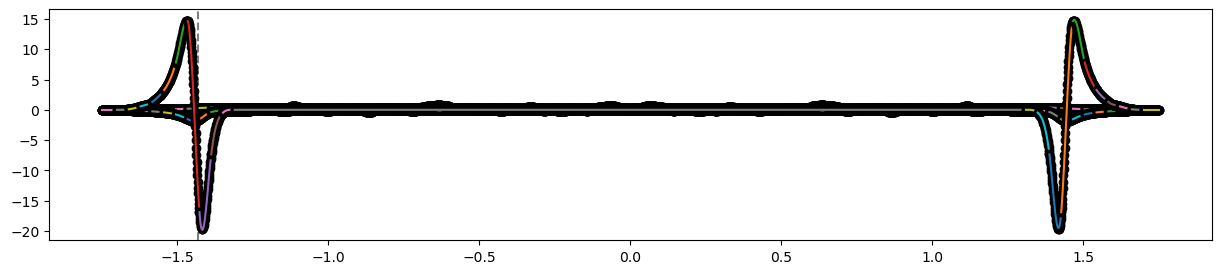

In [5]:
fig, ax = plt.subplots(figsize=(15, 3))
plt.axvline(x=-l_magn/2, color="gray", linestyle="--")
for index in range(max_multipole):
    pols = []
    
    # The actual data
    b = coeffs[:, index]
    
    for (ia, ib), pol in zip(segment_inds, all_pols[index]):
        bpmeth.plot_fit(ia,ib,zvals,b,pol,ax=ax,data=True)


In [7]:
class Magnet:
    isthick=True
    def __init__(self, segments, all_pols, z_edge, rho):
        """
        :param segments: List of (a,b) tuples defining the segments along z, entrance half of the magnet.
        :param all_pols: For each multipole, list of lists of polynomials for each segment, entrance half 
            of the magnet. The order of the multipoles is len(all_pols).
        :param z_edge: Longitudinal position of the edge of the magnet, to determine curvature.
        :param rho: Bending radius of the magnet.
        """
        self.segments = segments
        self.all_pols = all_pols
        self.z_edge = z_edge
        self.rho = rho
        
        self.order = len(all_pols)  
    
        self.fieldexpansion_generated = False
        
        self.length = segments[-1][1] - segments[0][0]
        
    def rescale(self, scalefactor):
        self.fieldexpansion_generated = False
        self.all_pols = [[pol*scalefactor for pol in pols] for pols in self.all_pols]
        return self
        
    def copy(self):
        return Magnet(self.segments, self.all_pols, self.z_edge, self.rho)
    
    def plot(self):
        fig, ax = plt.subplots(figsize=(15, 3))
        ax.axvline(x=self.z_edge, color="gray", linestyle="--")
        for index in range(self.order):
            pols = []
            
            for (a, b), pol in zip(self.segments, self.all_pols[index]):
                zz = np.linspace(a, b, 100)
                ax.plot(zz, bpmeth.poly_fit.poly_val(pol, zz))
    
    def create_fieldexpansion(self):
        
        expansions=[]
        hamiltonians = []
        
        segments = np.array(self.segments)
        
        bfuncs = [[bpmeth.poly_print(self.all_pols[i][j], x="s") for j in range(len(self.all_pols[i]))] for i in range(self.order)]
        
        for i in range(len(segments)):
            bb = [bbs[i] for bbs in bfuncs]   
            
            if segments[i,0] < self.z_edge:  # Incoming drift
                startpoint = segments[i,0]
                endpoint = min(segments[i,1], self.z_edge)
                length = endpoint - startpoint
                
                expansion = bpmeth.FieldExpansion(b=bb, hs="0", nphi=3)
                hamiltonian = bpmeth.Hamiltonian(length, 0, expansion, s_start = startpoint)

                expansions.append(expansion)         
                hamiltonians.append(hamiltonian)
                
            if segments[i,1] > self.z_edge and segments[i,0] < -self.z_edge:  # Body part
                startpoint = max(segments[i,0], self.z_edge)
                endpoint = min(segments[i,1], -self.z_edge)
                length = endpoint - startpoint

                expansion = bpmeth.FieldExpansion(b=bb, hs=f"{1/self.rho}", nphi=2)
                hamiltonian = bpmeth.Hamiltonian(length, 1/rho, expansion, s_start = startpoint)

                expansions.append(expansion)         
                hamiltonians.append(hamiltonian)            
                
            if segments[i,1] > -self.z_edge:  # Outgoing drift
                startpoint = max(segments[i,0], -self.z_edge)
                endpoint = segments[i,1]
                length = endpoint - startpoint
                
                expansion = bpmeth.FieldExpansion(b=bb, hs="0", nphi=2)
                hamiltonian = bpmeth.Hamiltonian(length, 0, expansion, s_start = startpoint)
                
                expansions.append(expansion)
                hamiltonians.append(hamiltonian)
        
        self.hamiltonians = hamiltonians
        self.fieldexpansion_generated = True
                
    def track(self, particles, ivp_opt={}, plot=False):
        if not self.fieldexpansion_generated:
            self.create_fieldexpansion()
            
        ivp_opt = {"rtol": 1e-12, "atol": 1e-12}

        sols = []
        for hamiltonian in self.hamiltonians:
            sol = hamiltonian.track(particles, ivp_opt=ivp_opt, return_sol=True)
            sols.append(sol)
        
        if plot:
            fig, ax = plt.subplots(2, sharex=True)
            for i in range(len(particles.x)):
                tlist = np.concatenate([sol[i].t for sol in sols])
                xlist = np.concatenate([sol[i].y[0] for sol in sols])
                ylist = np.concatenate([sol[i].y[1] for sol in sols])
                ax[0].scatter(tlist, xlist, marker='.')
                ax[1].scatter(tlist, ylist, marker='.')

            ax[0].set_xlabel("s")
            ax[1].set_xlabel("s")
            ax[0].set_ylabel("x")
            ax[1].set_ylabel("y")
        

In [8]:
Daan = Magnet(segments, all_pols, -l_magn/2, rho)

In [9]:
def objective(scalefactor):
    print("Trying scal factor:", scalefactor, end='\r')
    pp = xt.Particles(s=magnet_start)
    magnet = Daan.copy()
    magnet.rescale(scalefactor)
    magnet.track(pp)
    return abs(np.mean(pp.x))

# bounds = bounds=(0.99973, 0.99974)  # For tanh magnet
bounds = (0.9643, 0.965)  #For Daan magnet
result = sc.optimize.minimize_scalar(objective, bounds=bounds, method="bounded", options={"xatol":1e-8})
scalefactor = result.x
print(f"Best scale factor: {scalefactor}")
print(f"Resulting (absolute value) closed orbit at exit: {objective(scalefactor)} m")

Best scale factor: 0.96462609397719155
Resulting (absolute value) closed orbit at exit: 1.0182526348974775e-09 m


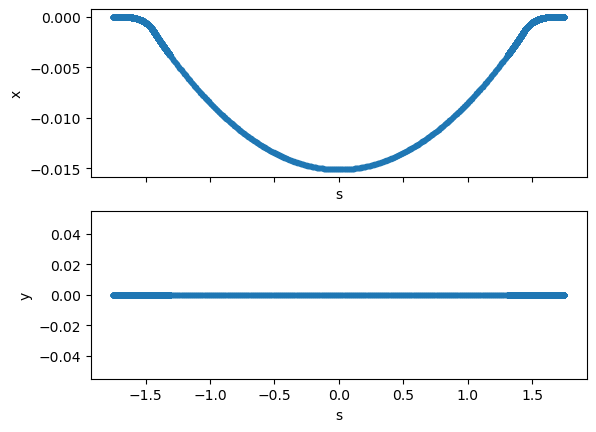

In [10]:
pp = xt.Particles(s=magnet_start)
Daan.rescale(scalefactor)
Daan.track(pp, plot=True)

# HeLICS lattice

In [11]:
##################
# HeLICS lattice #
##################

mad=Madx()
mad.call("/home/silke/Documents/HeLICS/HeLICS.str")
mad.call("/home/silke/Documents/HeLICS/HeLICS.seq")
mad.beam()
mad.use("he_ring")

def match_tunes(madx,qx,qy):
    madx.input(f'''
    use, sequence=he_ring;
    MATCH;
    GLOBAL, Q2={qy},Q1={qx};
    vary, name=qd_k1, step=0.0000001;
    vary, name=qf_k1, step=0.0000001;
    simplex, calls=5000, tolerance=1E-10;
    endmatch;''')
    qf = madx.eval('qf_k1')
    qd = madx.eval('qd_k1')
    return qf,qd

def match_disp(madx):
    madx.input(f'''
    use, sequence=he_ring;
    MATCH;
    constraint, sequence=he_ring, range = "qf2b", DX=0.0;
    vary, name=qb_k1, step=0.0000001;
    jacobian, calls=5000, tolerance=1E-10;
    endmatch;''')
    qb = madx.eval('qb_k1') 
    return qb

print("Matched to Qx 2.4, Qy 1.2 with quadrupole strengths qf, qd = ", match_tunes(mad, 2.4, 1.2))

line=xt.Line.from_madx_sequence(mad.sequence.he_ring)
line.configure_bend_model(edge='full', core='adaptive', num_multipole_kicks=30)
line.particle_ref=xt.Particles(mass0=0.931494 * 4.001506179127e9, q0=2., energy0=(0.931494 * 4.001506179127 + 0.02)*1e9)  # Energy in eV, top energy
start_elem = "lssc"
line.cycle(name_first_element=start_elem, inplace=True)  # Such that dipole is not spanning over end-beginning of lattice
    
tw0 = line.twiss4d()
tab0 = line.get_table()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.10.29 18:05:00      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ==== DRIFTS =====

q_drift        = 1.05;

mb_drift       = 0.2;

mb_quad_drift  = 0.15; // space mb2q + endcoils Q

sx_drift       = 0.5;

ss_drift       =  4.;



! ==== DIPOLE GEOMETRY ====

edge          = 30./180.*pi;

ein1          := edge;  

eout1         := edge;

fint	      = 0.42;

hgap          = 0.035;



phi            = 60./180.*pi;

rho            = 2.737;

mb_len        := phi*rho;



! ==== QUADRUPOLE STRENGTHS =====

quad_len       = 0.2;

qb_len         = 0.400;

qf_len         = 0.400;

qd_len         = 0.235;

sx_len         = 0.115;



mb_k1          = -0.11; 

qb_k1          = 2.8067743015574944;

qf_k1          = 2.6880579191671385;  

qd_k1          = -2.9440570148491068;



! ===

Converting sequence "he_ring": 100%|██████████| 73/73 [00:00<00:00, 1216.71it/s]


In [12]:
line_Daan = line.copy()
tab_Daan = line_Daan.get_table()
dipole_names = tab_Daan['name'][tab_Daan["element_type"] == 'Bend']
for dipole in dipole_names:
    print(f"Replacing dipole {dipole} with Daan fieldmap magnet.")
    dipole_s = float(tab_Daan['s_center'][tab_Daan["name"]==dipole])
    line_Daan.remove(dipole)
    line_Daan.insert(f"{dipole}_Daan", Daan, at=dipole_s)
tab_Daan = line_Daan.get_table()

/tmp/silke/ipykernel_735068/3978745399.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dipole_s = float(tab_Daan['s_center'][tab_Daan["name"]==dipole])


Replacing dipole mb2a with Daan fieldmap magnet.


Slicing line: 100%|██████████| 73/73 [00:00<00:00, 108077.72it/s]


Replacing dipole mb2b with Daan fieldmap magnet.


Slicing line: 100%|██████████| 72/72 [00:00<00:00, 126355.60it/s]


Replacing dipole mb3a with Daan fieldmap magnet.


Slicing line: 100%|██████████| 71/71 [00:00<00:00, 97033.43it/s]


Replacing dipole mb3b with Daan fieldmap magnet.


Slicing line: 100%|██████████| 70/70 [00:00<00:00, 99458.43it/s]


Replacing dipole mb1a with Daan fieldmap magnet.


Slicing line: 100%|██████████| 69/69 [00:00<00:00, 134921.67it/s]


Replacing dipole mb1b with Daan fieldmap magnet.


Slicing line: 100%|██████████| 63/63 [00:00<00:00, 139958.24it/s]


In [13]:
tw_Daan = line_Daan.twiss4d(include_collective=True)

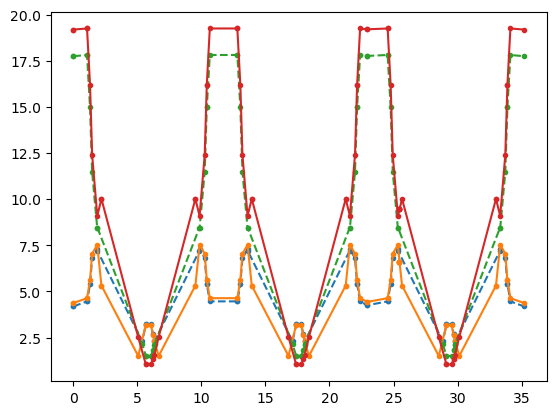

In [14]:
fig,ax=plt.subplots()
ax.plot(tw_Daan.s,tw_Daan.betx,label='betx Daan',ls='--',marker='.')
ax.plot(tw0.s,tw0.betx,label='betx design',ls='-',marker='.')
ax.plot(tw_Daan.s,tw_Daan.bety,label='bety Daan',ls='--',marker='.')
ax.plot(tw0.s,tw0.bety,label='bety design',ls='-',marker='.')


In [15]:
print(tw0.qx,tw_Daan.qx)
print(tw0.qy,tw_Daan.qy)
print(tw0.dqx,tw_Daan.dqx)
print(tw0.dqy,tw_Daan.dqy)

2.3999998874588675 2.438683937163209
1.2000022673265172 1.0296650808658037
-2.3483814380265144 -2.4181114342791687
-3.4489701992890254 -2.9718008951906683
